# Final Project Analysis: CP1-24

This notebook demonstrates the analysis of GPS motion data recorded along a sine wave path using the Phyphox app. The notebook includes:
1. A plot of GPS motion with a non-linear fit.
2. FFT analysis of GPS data in the frequency domain.
3. Inverse FFT analysis to visualize the reconstructed mean frequency.

## Instructions to Run the Notebook
1. Ensure all required Python packages (`numpy`, `pandas`, `matplotlib`, `scipy`) are installed.
2. Place the GPS data files and markdown metadata files in the appropriate folders:
   - Data CSV files in the `data/csv/` directory.
   - Metadata markdown files in the `data/markdown/` directory.
3. Run the notebook cells sequentially.

## Bibliography
- [Phyphox App Documentation](https://phyphox.org)
- [NumPy Documentation](https://numpy.org/doc/)
- [Matplotlib Documentation](https://matplotlib.org/)
- Any other sources used...


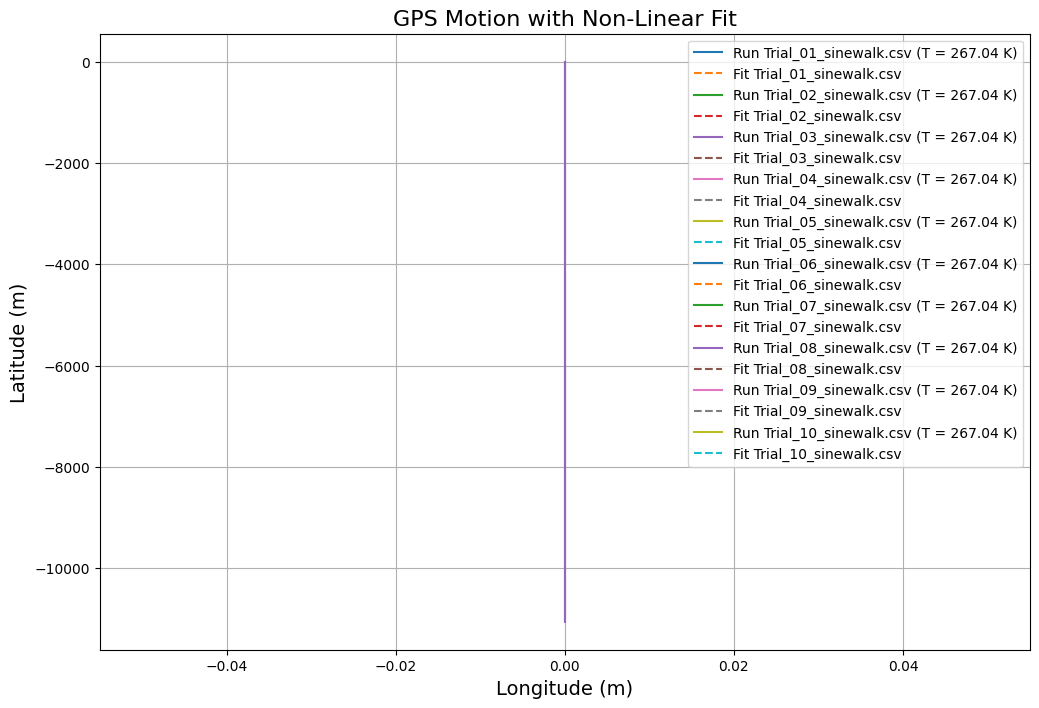

In [3]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Add the `code` directory to the system path
sys.path.append(os.path.abspath("/workspaces/CP1-24-final/dnxjay/code"))

# Import functions from final.py
from final import fahrenheit_to_kelvin, parse_temperature_from_markdown, sine_wave

# Define paths
csv_dir = "/workspaces/CP1-24-final/dnxjay/data/csv/"
markdown_dir = "/workspaces/CP1-24-final/dnxjay/data/markdown/"
csv_files = [f"Trial_{i:02d}_sinewalk.csv" for i in range(1, 11)]  # Updated file names
markdown_files = [f"Trial_{i:02d}_sinewalk.md" for i in range(1, 11)]

# Plot GPS motion with a non-linear fit
plt.figure(figsize=(12, 8))
for csv_file, md_file in zip(csv_files, markdown_files):
    try:
        # Parse temperature from markdown file
        md_path = os.path.join(markdown_dir, md_file)
        kelvin_temp = fahrenheit_to_kelvin(parse_temperature_from_markdown(md_path))
        
        # Load GPS data from CSV file
        csv_path = os.path.join(csv_dir, csv_file)
        data = pd.read_csv(csv_path)
        
        # Convert latitude and longitude to meters (relative to origin)
        x = (data["Longitude (°)"] - data["Longitude (°)"].iloc[0]) * 111320  # Longitude to meters
        y = (data["Latitude (°)"] - data["Latitude (°)"].iloc[0]) * 110540  # Latitude to meters

        # Fit a sine wave
        sine_fit = sine_wave(x, amplitude=10, frequency=0.001, phase=0)  # Adjust parameters as needed

        # Plot the original GPS data and the sine wave fit
        plt.plot(x, y, label=f"Run {csv_file} (T = {kelvin_temp:.2f} K)")
        plt.plot(x, sine_fit, linestyle='--', label=f"Fit {csv_file}")

    except Exception as e:
        print(f"Error processing {csv_file} or {md_file}: {e}")

# Configure the plot
plt.xlabel("Longitude (m)", fontsize=14)
plt.ylabel("Latitude (m)", fontsize=14)
plt.title("GPS Motion with Non-Linear Fit", fontsize=16)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()



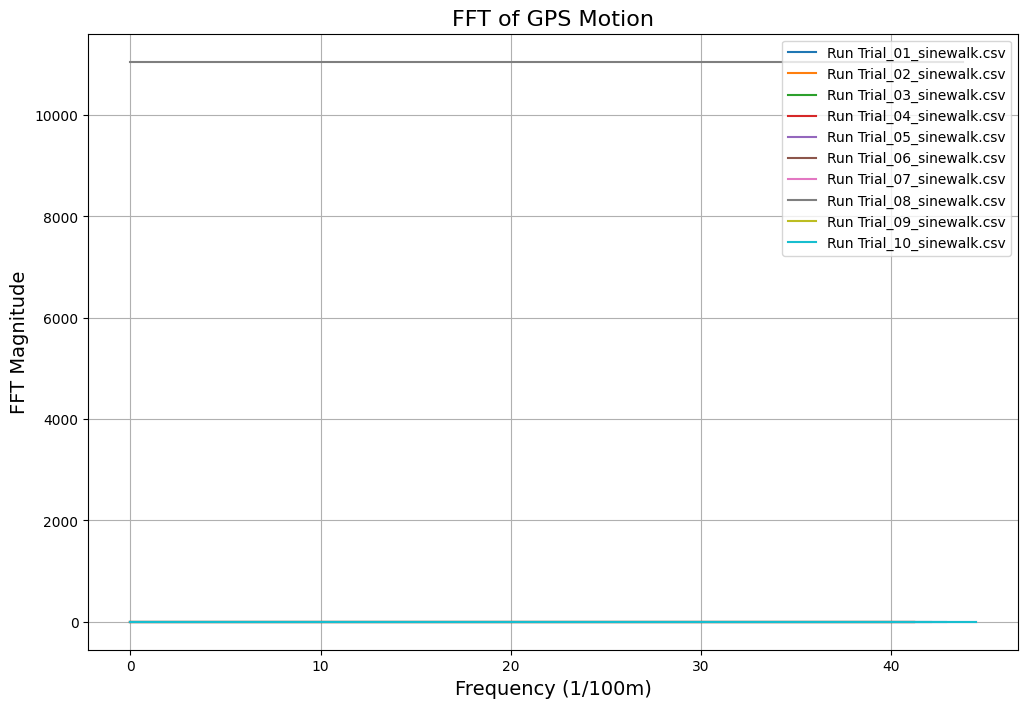

In [2]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Add the `code` directory to the system path
sys.path.append(os.path.abspath("/workspaces/CP1-24-final/dnxjay/code"))

# Import functions from final.py
from final import fft_with_check, calculate_frequency_axis

# Define paths
csv_dir = "/workspaces/CP1-24-final/dnxjay/data/csv/"
csv_files = [f"Trial_{i:02d}_sinewalk.csv" for i in range(1, 11)]

# Plot FFT of each walk
plt.figure(figsize=(12, 8))
for csv_file in csv_files:
    try:
        # Load GPS data
        csv_path = os.path.join(csv_dir, csv_file)
        data = pd.read_csv(csv_path)

        # Convert latitude to meters (relative to origin)
        y = (data["Latitude (°)"] - data["Latitude (°)"].iloc[0]) * 110540  # Latitude to meters

        # Compute FFT
        fft_result = fft_with_check(y)
        fft_magnitude = np.abs(fft_result[: len(y) // 2])  # Magnitude of FFT

        # Compute frequency axis (in 1/100m)
        freq = calculate_frequency_axis(len(y), sampling_interval=1 / 100)

        # Plot FFT magnitude
        plt.plot(freq, fft_magnitude, label=f"Run {csv_file}")

    except Exception as e:
        print(f"Error processing {csv_file}: {e}")

# Configure the plot
plt.xlabel("Frequency (1/100m)", fontsize=14)
plt.ylabel("FFT Magnitude", fontsize=14)
plt.title("FFT of GPS Motion", fontsize=16)
plt.legend(fontsize=10, loc="upper right")
plt.grid(True)
plt.show()


CSV files: ['Trial_01_sinewalk.csv', 'Trial_02_sinewalk.csv', 'Trial_03_sinewalk.csv', 'Trial_04_sinewalk.csv', 'Trial_05_sinewalk.csv', 'Trial_06_sinewalk.csv', 'Trial_07_sinewalk.csv', 'Trial_08_sinewalk.csv', 'Trial_09_sinewalk.csv', 'Trial_10_sinewalk.csv']


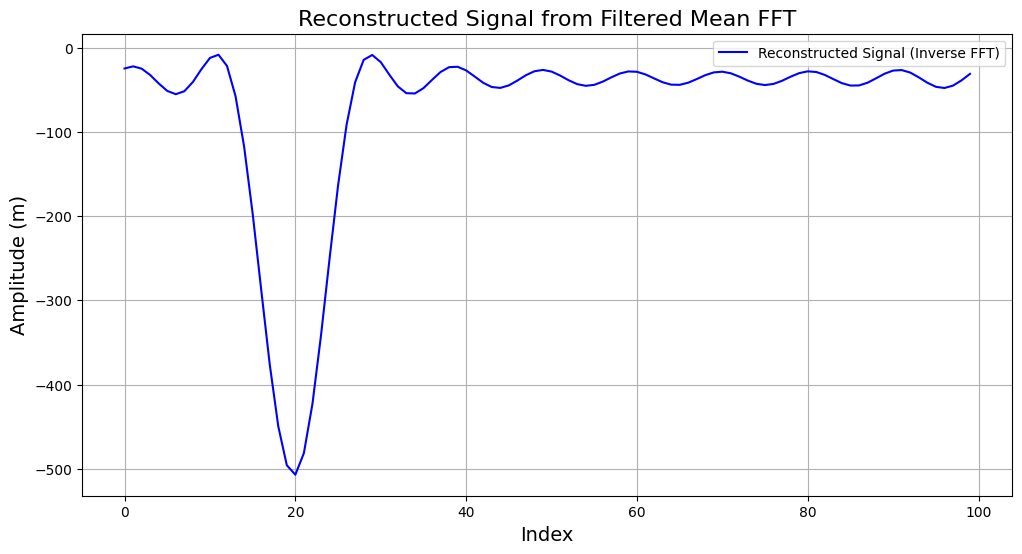

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Define paths
csv_dir = "/workspaces/CP1-24-final/dnxjay/data/csv/"
csv_files = [f"Trial_{i:02d}_sinewalk.csv" for i in range(1, 11)]

# Debugging: Print the available files
print("CSV files:", csv_files)

# Initialize FFT accumulator with consistent shapes
fft_accumulator = []
uniform_length = 100  # Define a uniform length for resampling

for csv_file in csv_files:
    try:
        # Load GPS data
        csv_path = os.path.join(csv_dir, csv_file)
        data = pd.read_csv(csv_path)

        # Convert latitude to meters (relative to origin)
        y = (data["Latitude (°)"] - data["Latitude (°)"].iloc[0]) * 110540

        # Resample to uniform length
        original_x = np.linspace(0, 1, len(y))
        new_x = np.linspace(0, 1, uniform_length)
        interpolator = interp1d(original_x, y, kind='linear')
        y_resampled = interpolator(new_x)

        # Compute FFT
        fft_result = np.fft.fft(y_resampled)
        fft_accumulator.append(fft_result)

    except Exception as e:
        print(f"Error processing {csv_file}: {e}")

# Calculate the mean FFT
if len(fft_accumulator) > 0:
    fft_mean = np.mean(np.array(fft_accumulator), axis=0)

    # Filter the mean FFT (example: retain low frequencies only)
    filtered_fft_mean = np.copy(fft_mean)
    frequency_cutoff = 10  # Example cutoff frequency
    filtered_fft_mean[frequency_cutoff:] = 0  # Zero out higher frequencies

    # Perform inverse FFT
    inverse_fft = np.fft.ifft(filtered_fft_mean).real

    # Plot the reconstructed signal
    plt.figure(figsize=(12, 6))
    plt.plot(inverse_fft, label="Reconstructed Signal (Inverse FFT)", color="blue")
    plt.xlabel("Index", fontsize=14)
    plt.ylabel("Amplitude (m)", fontsize=14)
    plt.title("Reconstructed Signal from Filtered Mean FFT", fontsize=16)
    plt.legend(fontsize=10)
    plt.grid(True)
    plt.show()
else:
    print("No valid FFT results to process.")
